In [ ]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import Input
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import shuffle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load model
model = load_model('/content/drive/MyDrive/mri_classifier.keras')
model.summary()

# Choose bottleneck layer
intermediate_layer_index = 6  # Change if needed
intermediate_layer = model.layers[intermediate_layer_index]
input_shape = (254, 254, 1)

# Bottleneck model
inputs = Input(shape=input_shape)
x = inputs
for i in range(intermediate_layer_index + 1):
    x = model.layers[i](x)
bottleneck_model = Model(inputs=inputs, outputs=x)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 252, 252, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 252, 252, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 124, 124, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,740,746 (452.96 MB)

 Trainable params: 59,369,924 (226.48 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 59,369,926 (226.48 MB)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images_from_folder(folder, max_files=None):
    images = []
    for i, filename in enumerate(sorted(os.listdir(folder))):
        if max_files and i >= max_files:
            break
        img = load_img(os.path.join(folder, filename), color_mode='grayscale', target_size=(254, 254))
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

In [ ]:
def get_activations(imgs):
    return bottleneck_model.predict(imgs, batch_size=32, verbose=0)


In [ ]:
import zipfile
import os

# Replace 'your_file.zip' with the actual filename
zip_path = '/content/cav_dataset1.zip'
extract_dir = 'extracted_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to: {os.path.abspath(extract_dir)}")

Files extracted to: /content/extracted_dataset


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def extract_and_save_activations_one_by_one(folder_path, model, output_path, target_size=(254, 254)):
    files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    output_shape = model.output_shape[1:]  # e.g., (60, 60, 256)

    # Create output file in write mode
    np.savez_compressed(output_path, dummy=np.zeros((1, *output_shape)))  # placeholder init

    for idx, fname in enumerate(files):
        img_path = os.path.join(folder_path, fname)
        img = load_img(img_path, color_mode='grayscale', target_size=target_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # shape (1, h, w, 1)

        # Get activation
        act = model.predict(img_array, verbose=0)

        # Save to individual .npy file to avoid RAM buildup
        np.save(f"{output_path}_activation_{idx}.npy", act)

        if idx % 100 == 0:
            print(f"✅ Processed {idx} images")

    print("✅ All activations saved individually.")


In [ ]:
extract_and_save_activations_one_by_one(
    folder_path='/content/extracted_dataset/cav_dataset/pituitary',
    model=bottleneck_model,
    output_path='/content/pi_act/pi'
)


✅ Processed 0 images
✅ Processed 100 images
✅ Processed 200 images
✅ All activations saved individually.


In [ ]:
extract_and_save_activations_one_by_one(
    folder_path='/content/extracted_dataset/cav_dataset/glioma',
    model=bottleneck_model,
    output_path='/content/gi_act/gi'
)


✅ Processed 0 images
✅ Processed 100 images
✅ Processed 200 images
✅ All activations saved individually.


In [ ]:
extract_and_save_activations_one_by_one(
    folder_path='/content/extracted_dataset/cav_dataset/meningioma',
    model=bottleneck_model,
    output_path='/content/me_act/me'
)


✅ Processed 0 images
✅ Processed 100 images
✅ Processed 200 images
✅ Processed 300 images
✅ All activations saved individually.


In [ ]:
extract_and_save_activations_one_by_one(
    folder_path='/content/extracted_dataset/cav_dataset/random',
    model=bottleneck_model,
    output_path='/content/ra_act/ra'
)

✅ Processed 0 images
✅ Processed 100 images
✅ Processed 200 images
✅ Processed 300 images
✅ Processed 400 images
✅ Processed 500 images
✅ Processed 600 images
✅ All activations saved individually.


In [ ]:
extract_and_save_activations_one_by_one(
    folder_path='/content/extracted_dataset/cav_dataset/test_glioma',
    model=bottleneck_model,
    output_path='/content/test_act/test'
)


✅ Processed 0 images
✅ Processed 100 images
✅ All activations saved individually.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle

# Helper to load activations from saved files
def load_activations_from_folder(folder_path, max_files=None):
    acts = []
    for i, filename in enumerate(sorted(os.listdir(folder_path))):
        if max_files and i >= max_files:
            break
        if filename.endswith('.npy'):
            acts.append(np.load(os.path.join(folder_path, filename)))
    return np.array(acts)

# Load all activations
concept_folders = {
    'Pituitary': '/content/pi_act',
    'Glioma': '/content/gi_act',
    'Meningioma': '/content/me_act',
}
random_acts = load_activations_from_folder('/content/ra_act/')
test_acts = load_activations_from_folder('/content/test_act/')


In [ ]:
def train_cav(concept_acts, random_acts):
    X = np.concatenate([concept_acts, random_acts])
    y = np.array([1]*len(concept_acts) + [0]*len(random_acts))
    X, y = shuffle(X.reshape(len(X), -1), y)
    clf = SGDClassifier().fit(X, y)
    return clf.coef_.reshape(concept_acts.shape[1:])

def compute_tcav_score(cav, test_acts):
    dot_prods = np.tensordot(test_acts, cav, axes=len(cav.shape))
    return np.mean(dot_prods > 0)

In [ ]:
scores = {}
for concept, folder in concept_folders.items():
    print(f"Processing concept: {concept}")
    concept_acts = load_activations_from_folder(folder)
    cav = train_cav(concept_acts, random_acts)
    score = compute_tcav_score(cav, test_acts)
    scores[concept] = score

Processing concept: Pituitary
Processing concept: Glioma
Processing concept: Meningioma


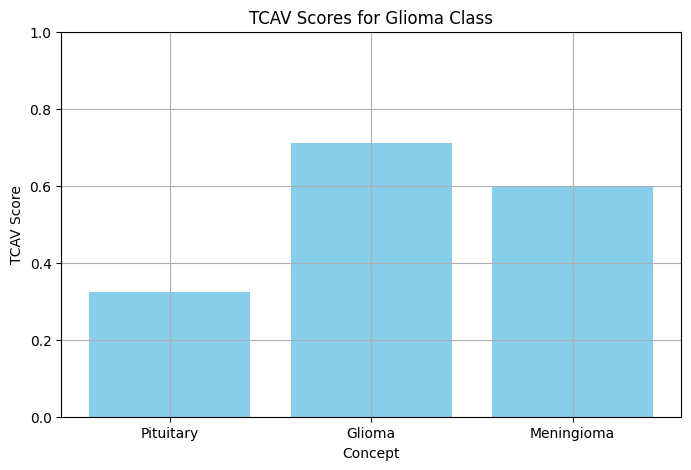

Pituitary: 0.325
Glioma: 0.711
Meningioma: 0.596


In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(scores.keys(), scores.values(), color='skyblue')
plt.title('TCAV Scores for Glioma Class')
plt.xlabel('Concept')
plt.ylabel('TCAV Score')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Print values
for concept, score in scores.items():
    print(f"{concept}: {score:.3f}")